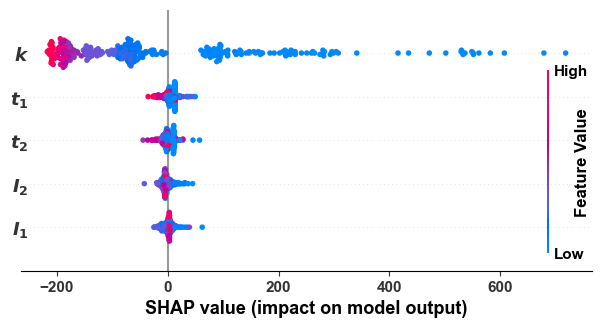

In [184]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Step 1: 加载数据
data = pd.read_csv('nomal_current_feature.csv')  # 替换为您的文件路径

# 将特征名称改为带下标的格式
features = data[['I1', 'k', 't1', 'I2', 't2']]
features.columns = ['$I_1$', '$k$', '$t_1$', '$I_2$', '$t_2$']
target = data['ttf']

# Step 2: 训练模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(features, target)

# Step 3: 初始化 SHAP 分析器
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

# 使用 SHAP 自带设置绘图和保存 SHAP 图像的函数
def save_custom_shap_plot(shap_values, features, filename="shap_summary_plot.svg"):
    # 创建 SHAP 图并设置 show=False 保存图像
    shap.summary_plot(shap_values, features, plot_type="dot", show=False, color_bar=True)
    
    # 设置颜色条标题为 Low 和 High
    cbar = plt.gcf().axes[-1]  # 获取颜色条的轴对象
    cbar.set_ylabel('Feature Value', fontsize=12, labelpad=-10)  # 设置颜色条标题
    cbar.set_yticks([cbar.get_ylim()[0], cbar.get_ylim()[1]])  # 设置颜色条刻度位置为最小值和最大值
    cbar.set_yticklabels(['Low', 'High'])  # 设置颜色条刻度标签为 'Low' 和 'High'
    
    # 获取颜色条边界框并手动调整其尺寸
    box = cbar.get_position()
    cbar.set_position([box.x0 - 0.1, box.y0 + 0.05, 0.02, box.height * 0.7])  # [左, 底, 宽度, 高度]，调整宽度和位置，使颜色条变粗变短
    
    # 调整特征名的位置使其向右移动一些
    ax = plt.gca()
    ytick_labels = ax.get_yticklabels()
    for label in ytick_labels:
        label.set_x(label.get_position()[0] + 0.07)  # 向右移动特征名
    
    # 保存为 SVG 矢量图格式
    plt.savefig(filename, format="svg", bbox_inches='tight', pad_inches=0.1)
    plt.show()

# 生成并保存 SHAP 点图
save_custom_shap_plot(shap_values, features, filename="shap_summary_plot.svg")


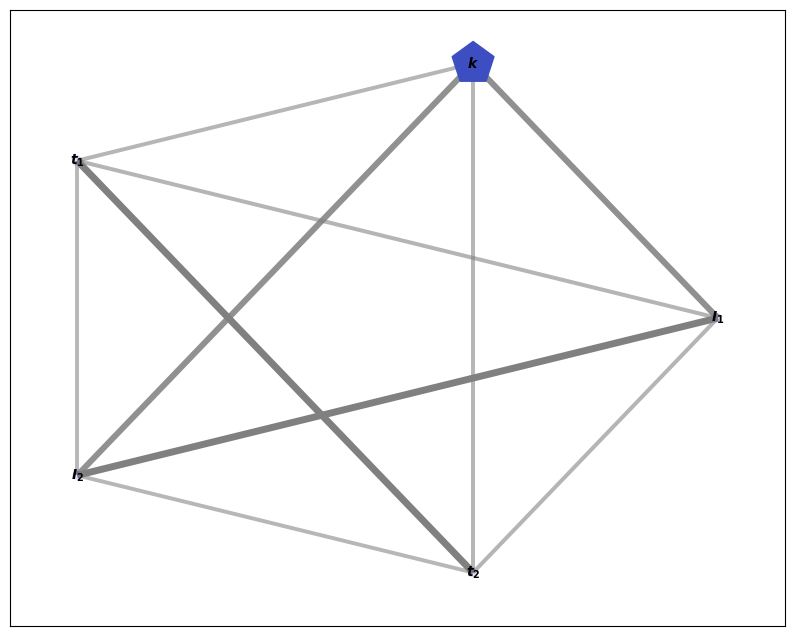

In [186]:


# 生成表示特征之间相关性的网络图
def create_feature_correlation_network(features, shap_values, filename="feature_correlation_network.svg"):
    # 计算特征之间的相关性矩阵
    corr_matrix = features.corr()
    
    # 初始化网络图
    G = nx.Graph()
    
    # 设置节点颜色，使用SHAP图中颜色条的两端颜色
    low_color = plt.get_cmap("coolwarm")(0)  # SHAP图中低值颜色
    high_color = plt.get_cmap("coolwarm")(1)  # SHAP图中高值颜色

    # 获取每个特征的重要性（绝对值的平均SHAP值）
    feature_importance = np.abs(shap_values).mean(axis=0)
    max_importance = feature_importance.max()

    # 添加节点到网络中
    for i, feature in enumerate(features.columns):
        G.add_node(
            feature,
            size=feature_importance[i] / max_importance * 1000,  # 节点大小与特征重要性成比例
            color=low_color if feature_importance[i] < feature_importance.mean() else high_color,  # 根据重要性设置节点颜色
            alpha=0.1 + 0.9 * (feature_importance[i] / max_importance)  # 越重要透明度越高
        )

    # 添加边到网络中，边的透明度和粗细与相关性成比例
    for i, feature_i in enumerate(features.columns):
        for j, feature_j in enumerate(features.columns):
            if i < j:  # 只考虑上三角矩阵，避免重复
                corr = corr_matrix.iloc[i, j]
                if abs(corr) > 0.1:  # 只考虑相关性大于阈值的特征对
                    G.add_edge(
                        feature_i,
                        feature_j,
                        weight=abs(corr) * 5,  # 边的粗细与相关性成比例
                        alpha=abs(corr)  # 越不相关透明度越低
                    )

    # 绘制五边形网络图
    pos = nx.circular_layout(G)  # 使用 circular 布局算法使节点形成多边形
    plt.figure(figsize=(10, 8))
    
    # 绘制节点
    node_sizes = [G.nodes[node]['size'] for node in G]
    node_colors = [G.nodes[node]['color'] for node in G]
    node_alphas = [G.nodes[node]['alpha'] for node in G]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=node_alphas, node_shape='p')  # 使用五边形节点
    
    # 绘制边
    edges = G.edges(data=True)
    for edge in edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(edge[0], edge[1])],
            width=edge[2]['weight'],
            alpha=edge[2]['alpha'],
            edge_color='grey'
        )
    
    # 绘制节点标签
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    
    # 保存网络图
    plt.savefig(filename, format="svg", bbox_inches='tight', pad_inches=0.1)
    plt.show()

# 生成并保存特征相关性网络图
create_feature_correlation_network(features, shap_values, filename="feature_correlation_network.svg")


